# TDEM Step off experiment

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook was used to produce Figure 7 in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

import os
import ipywidgets

%matplotlib inline

## model parameters

In [3]:
simDir = "TDEM_fields_response_1km"
simDirbackground = "TDEM_fields_response_1km_background"

In [4]:
sigma_air = 1e-5
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 1e6

casing_diameter = 10e-2  
casing_t = 10e-3

mur_casing = 1.
casing_l = 1000
csz = 2.5 

In [5]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [6]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

In [7]:
timeSteps = [(1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)]

model.timeSteps = timeSteps
print(model.timeSteps.sum())
print(len(model.timeSteps))

0.20422000000000004
187


In [8]:
model.diffusion_distance(2e-1)

5641.895835477563

## Mesh

In [9]:
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [10]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8,
    npadz = 17,
    csz = csz,
#     pfz = 1.5,
)

509712


/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


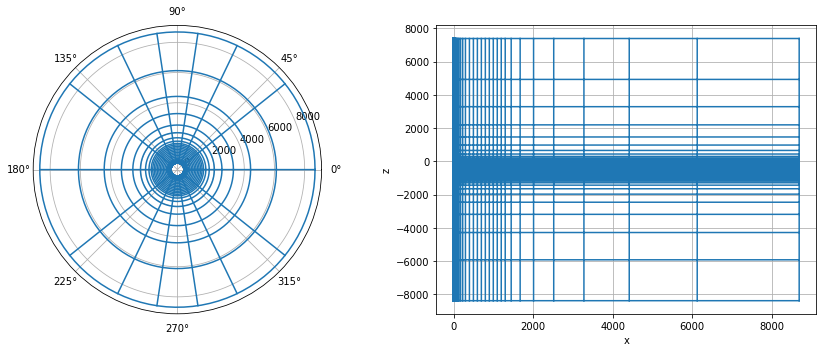

In [11]:
print(meshGen.mesh.nC)
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

In [12]:
physprops = casingSim.model.PhysicalProperties(
    modelParameters=model,
    meshGenerator=meshGen
)

In [13]:
from matplotlib.colors import LogNorm

[(-1250.0, 10.0), (-1250.0, 10.0)]

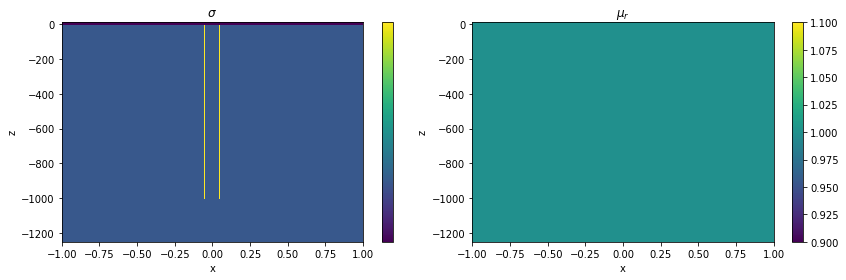

In [14]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

ax = physprops.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

## Survey

In [15]:
src = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

(-10.0, 10.0)

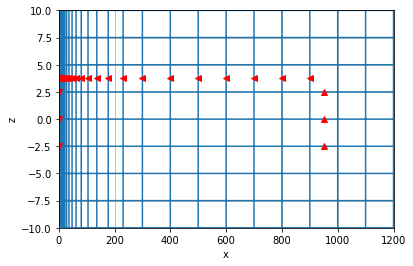

In [16]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 1200.])
ax.set_ylim([-10., 10.])

In [17]:
src.src_a_closest

array([0.04625   , 1.57079633, 0.        ])

(0.0, 60.0)

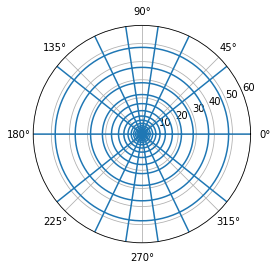

In [20]:
ax = meshGen.mesh.plotGrid(slice="z")
ax.set_rlim([0., 60.])

In [21]:
meshGen.mesh.vectorCCy[[3, 3+7]]*180/np.pi

array([ 90., 270.])

## Simulation

In [22]:
sim3D = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    src=src, 
)

In [23]:
# sim3D.write_py(include2D=True, includeDC=False)

uncomment the below to re-run the simulation

In [24]:
# run TDEM_fields_response_1km/simulation.py
# run TDEM_fields_response_1km_background/simulation.py

# Load the results

In [27]:
import os

In [28]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir,
    modelParameters=simDir + os.path.sep + 'ModelParameters.json',
    meshGenerator=simDir + os.path.sep + 'MeshParameters.json',
    src=simDir + os.path.sep + 'Source.json',
    fields_filename=simDir + os.path.sep + 'fields.npy'
)

sim_background = casingSim.run.SimulationTDEM(
    directory=simDirbackground,
    modelParameters=simDirbackground + os.path.sep + 'ModelParameters.json',
    meshGenerator=simDirbackground + os.path.sep + 'MeshParameters.json',
    src=simDirbackground + os.path.sep + 'Source.json',
    fields_filename=simDirbackground + os.path.sep + 'fields.npy'
)

In [29]:
jSolution = np.load(simDir + os.path.sep + 'fields.npy')
jSolution2D = np.load(simDir + os.path.sep + 'fields2D.npy')

jSolution_background = np.load(simDirbackground + os.path.sep + 'fields.npy')
jSolution2D_background = np.load(simDirbackground + os.path.sep + 'fields2D.npy')

In [30]:
sim.prob.model = sim.physprops.model
sim_background.prob.model = sim_background.physprops.model

In [31]:
%%time
# recreate the fields object
fields = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)
fields_background = sim_background.prob.fieldsPair(sim_background.meshGenerator.mesh, sim_background.survey)

CPU times: user 2min 24s, sys: 4.57 s, total: 2min 28s
Wall time: 2min 37s


In [32]:
fields[:,'jSolution',:] = jSolution
fields_background[:,'jSolution',:] = jSolution_background

# Plot Comparison

In [34]:
# Plot the charges
src_ind=0

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='j',  
    casing_outline=True, 
    theta_ind=0, 
    time_ind=0, 
    mod='casing', 
    extend_cb=None, 
    show_cb=True
):
    if mod in ['casing', 'difference']:
        s = sim
        f = fields
    elif mod == 'background':
        s = sim_background
        f = fields_background
        

    csim = s
    mesh2D = s.meshGenerator.create_2D_mesh().mesh
        
#     elif dim == '2D':
#         csim = sim2D
#         mesh2D = sim2D.meshGenerator.mesh
#         f = fields2D
#         theta_ind=0
        
    pp = csim.physprops
    src = csim.survey.srcList[src_ind]
    meshGen = csim.meshGenerator
    plotme = f[src, view, time_ind]
    
    if mod == 'difference':
        src = sim_background.survey.srcList[src_ind]
        plotme = plotme - fields_background[src, view, time_ind]
        
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 6))
        
    assert view.lower() in ['j', 'e', 'charge']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
    
    if view in ['j', 'e']:
        jplt = casingSim.face3DthetaSlice(
            meshGen.mesh, plotme, theta_ind=theta_ind
        )
        mirror_data = casingSim.face3DthetaSlice(
            meshGen.mesh, plotme, theta_ind=theta_ind + 7
        )
#         else:
#             mirror_data = jplt

        out = casingSim.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True, mirror_data=mirror_data, show_cb=show_cb,
            stream_threshold=clim[0] if clim is not None else None
#             extend_cb=extend_cb
        )
    elif view == 'charge':
        plotme = plotme.reshape(meshGen.mesh.vnC, order="F")
        
        out = mesh2D.plotImage(
                discretize.utils.mkvc(plotme[:, theta_ind, :]), ax=ax,
                mirror=True, clim=clim, pcolorOpts={
                    'cmap': 'bwr' if view == 'charge' else 'viridis', 
                }, 
                mirror_data=discretize.utils.mkvc(plotme[:, theta_ind+7 if theta_ind < 7 else theta_ind-7, :]),
            )
        if show_cb: 
            cb = plt.colorbar(
                out[0], ax=ax, extend = 'neither' if extend_cb is None else extend_cb
            )
        
#         if show_cb is True and clim is not None:
#             cb.set_clim(clim)
#             cb.update_ticks()
            
    ax.set_title(
        '{} {} \n theta = {:1.2f} \n time = {:1.2e}'.format(
            view, mod, meshGen.mesh.vectorCCy[theta_ind]*180/np.pi, csim.prob.times[time_ind]
            
        ), 
        fontsize=13
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
        
    # plot outline of casing
    if casing_outline is True: 
        m = model
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return out 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='j',  
    theta_ind=0, time_ind=0, mod='casing', 
    figwidth = 5
):
    
    if mod == "both":
        mod = ['casing', 'background', 'difference']
    else:
        mod = [mod]
        
    fig, ax = plt.subplots(1, len(mod), figsize=(figwidth*len(mod), 6))
    
    if len(mod) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, mod): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view,
            casing_outline=True, 
            theta_ind=theta_ind,
            time_ind=time_ind,
            mod=mod
        )
    
    plt.tight_layout()
    plt.show()

In [36]:
ipywidgets.interact(plotCasingResultsWidget,
    clim_max=ipywidgets.FloatText(value=0), 
    clim_min=ipywidgets.FloatText(value=0), 
    max_depth=ipywidgets.FloatText(value=1.5*model.casing_l), 
    max_r=ipywidgets.FloatText(value=0.15), 
    top=ipywidgets.FloatText(value=10.), 
    view=ipywidgets.ToggleButtons(options=['j', 'e', 'charge'], value='j'),  
    theta_ind=ipywidgets.IntSlider(min=0, max=len(sim.meshGenerator.hy), value=3),
    time_ind=ipywidgets.IntSlider(min=0, max=len(sim.modelParameters.timeSteps), value=0), 
    mod=ipywidgets.ToggleButtons(options=['casing', 'background', 'difference'], value='casing'),
    figwidth=ipywidgets.fixed(5),
)

<function __main__.plotCasingResultsWidget>

In [37]:
ipywidgets.interact(plotCasingResultsWidget,
    clim_max=ipywidgets.FloatText(value=1e-1), 
    clim_min=ipywidgets.FloatText(value=1e-11), 
    max_depth=ipywidgets.FloatText(value=1.5*model.casing_l), 
    max_r=ipywidgets.FloatText(value=1.5*model.casing_l), 
    top=ipywidgets.FloatText(value=10.), 
    view=ipywidgets.ToggleButtons(options=['j', 'e'], value='j'),  
    theta_ind=ipywidgets.IntSlider(min=0, max=len(sim.meshGenerator.hy), value=3),
    time_ind=ipywidgets.IntSlider(min=0, max=len(sim.modelParameters.timeSteps), value=0), 
    mod=ipywidgets.ToggleButtons(options=['casing', 'background', 'difference'], value='casing'),
    figwidth=ipywidgets.fixed(12),
    show_cb=True
)

<function __main__.plotCasingResultsWidget>

## Plan View 

In [38]:
nC = 200
hx = 3000.*np.ones(nC)/nC
plan_mesh = discretize.TensorMesh([hx, hx], x0='CC')

In [39]:
cylmesh = meshGen.mesh

In [40]:
CCcart = meshGen.mesh.cartesianGrid('CC')

In [41]:
def rotate_cyl2cart(vec, grid):
    x = vec[:, 0] * np.cos(grid[:, 1]) - vec[:, 1] * np.sin(grid[:, 1])
    y = vec[:, 0] * np.sin(grid[:, 1]) + vec[:, 1] * np.cos(grid[:, 1])
    z = vec[:, 2]
    
    return np.vstack([x, y, z]).T
    

In [42]:
vec = np.r_[1, 0, 0].reshape(1, 3)
grid = np.r_[1, np.pi/4, 0].reshape(1, 3)

print(rotate_cyl2cart(vec, grid))


vec = np.r_[0, 1, 0].reshape(1, 3)
grid = np.r_[1, np.pi/4, 0].reshape(1, 3)

print(rotate_cyl2cart(vec, grid))

[[0.70710678 0.70710678 0.        ]]
[[-0.70710678  0.70710678  0.        ]]


In [43]:
tree = cKDTree(CCcart[:cylmesh.vnC[:2].prod(),:2])
d, ii = tree.query(plan_mesh.gridCC, k=10)
inds = np.vstack([ii, ii+cylmesh.vnC[:2].prod()])

In [44]:
ii.shape[0]

40000

In [45]:
weights = 1./d
weights = utils.sdiag(1./weights.sum(1))*weights
weights = np.vstack([weights, weights])

In [46]:
def plot_depth_slice(
    time_ind=0,
    z_ind=400,
    ax=None, 
    mod='casing',
    clim_max=1e-4,
    clim_min=1e-11, 
    show_cb=True
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
        
    if mod == 'casing':
        j = fields[:, 'j', time_ind]
    elif mod == 'background':
        j = fields_background[:, 'j', time_ind]
    elif mod == 'difference':
        j = fields[:, 'j', time_ind] - fields_background[:, 'j', time_ind] 
        
    
    jCC = cylmesh.aveF2CCV * j
    jCC_cart = rotate_cyl2cart(jCC.reshape((cylmesh.nC, 3), order='F'), cylmesh.gridCC)
    
    jCCx = (jCC_cart[:, 0]).reshape(cylmesh.vnC, order='F')
    jCCy = (jCC_cart[:, 1]).reshape(cylmesh.vnC, order='F')
    
    jCCx_plt = utils.mkvc(jCCx[:, :, z_ind])
    jCCy_plt = utils.mkvc(jCCy[:, :, z_ind])
    jCC_plt = np.hstack([jCCx_plt, jCCy_plt])
    
    plot_me = (jCC_plt[inds]*weights).sum(1)
    
    plot_me.shape
    # rotate things
    jCCx = plot_me[:plan_mesh.nC].reshape(plan_mesh.vnC, order="F")
    jCCy = plot_me[plan_mesh.nC:].reshape(plan_mesh.vnC, order="F")
    
    jCCx = utils.mkvc(jCCx.T)
    jCCy = utils.mkvc(jCCy.T)
    
#     print(jCCx.shape)
    
    plot_me = np.hstack([jCCy, jCCx])

    ax.set_title("z={:1.1f}m, \n t={:1.1e}".format(
        cylmesh.vectorCCz[z_ind], sim.prob.times[time_ind]
    ))

    out = plan_mesh.plotImage(
        plot_me, view='vec', vType='CCv', ax=ax, pcolorOpts={'norm':LogNorm()},
        clim = [clim_min, clim_max]
    )
    
    if show_cb: 
        cb = plt.colorbar(out[0], ax=ax)
    
    ax.set_aspect(1)
    return out
    
#     plt.show()

<function __main__.plot_depth_slice>

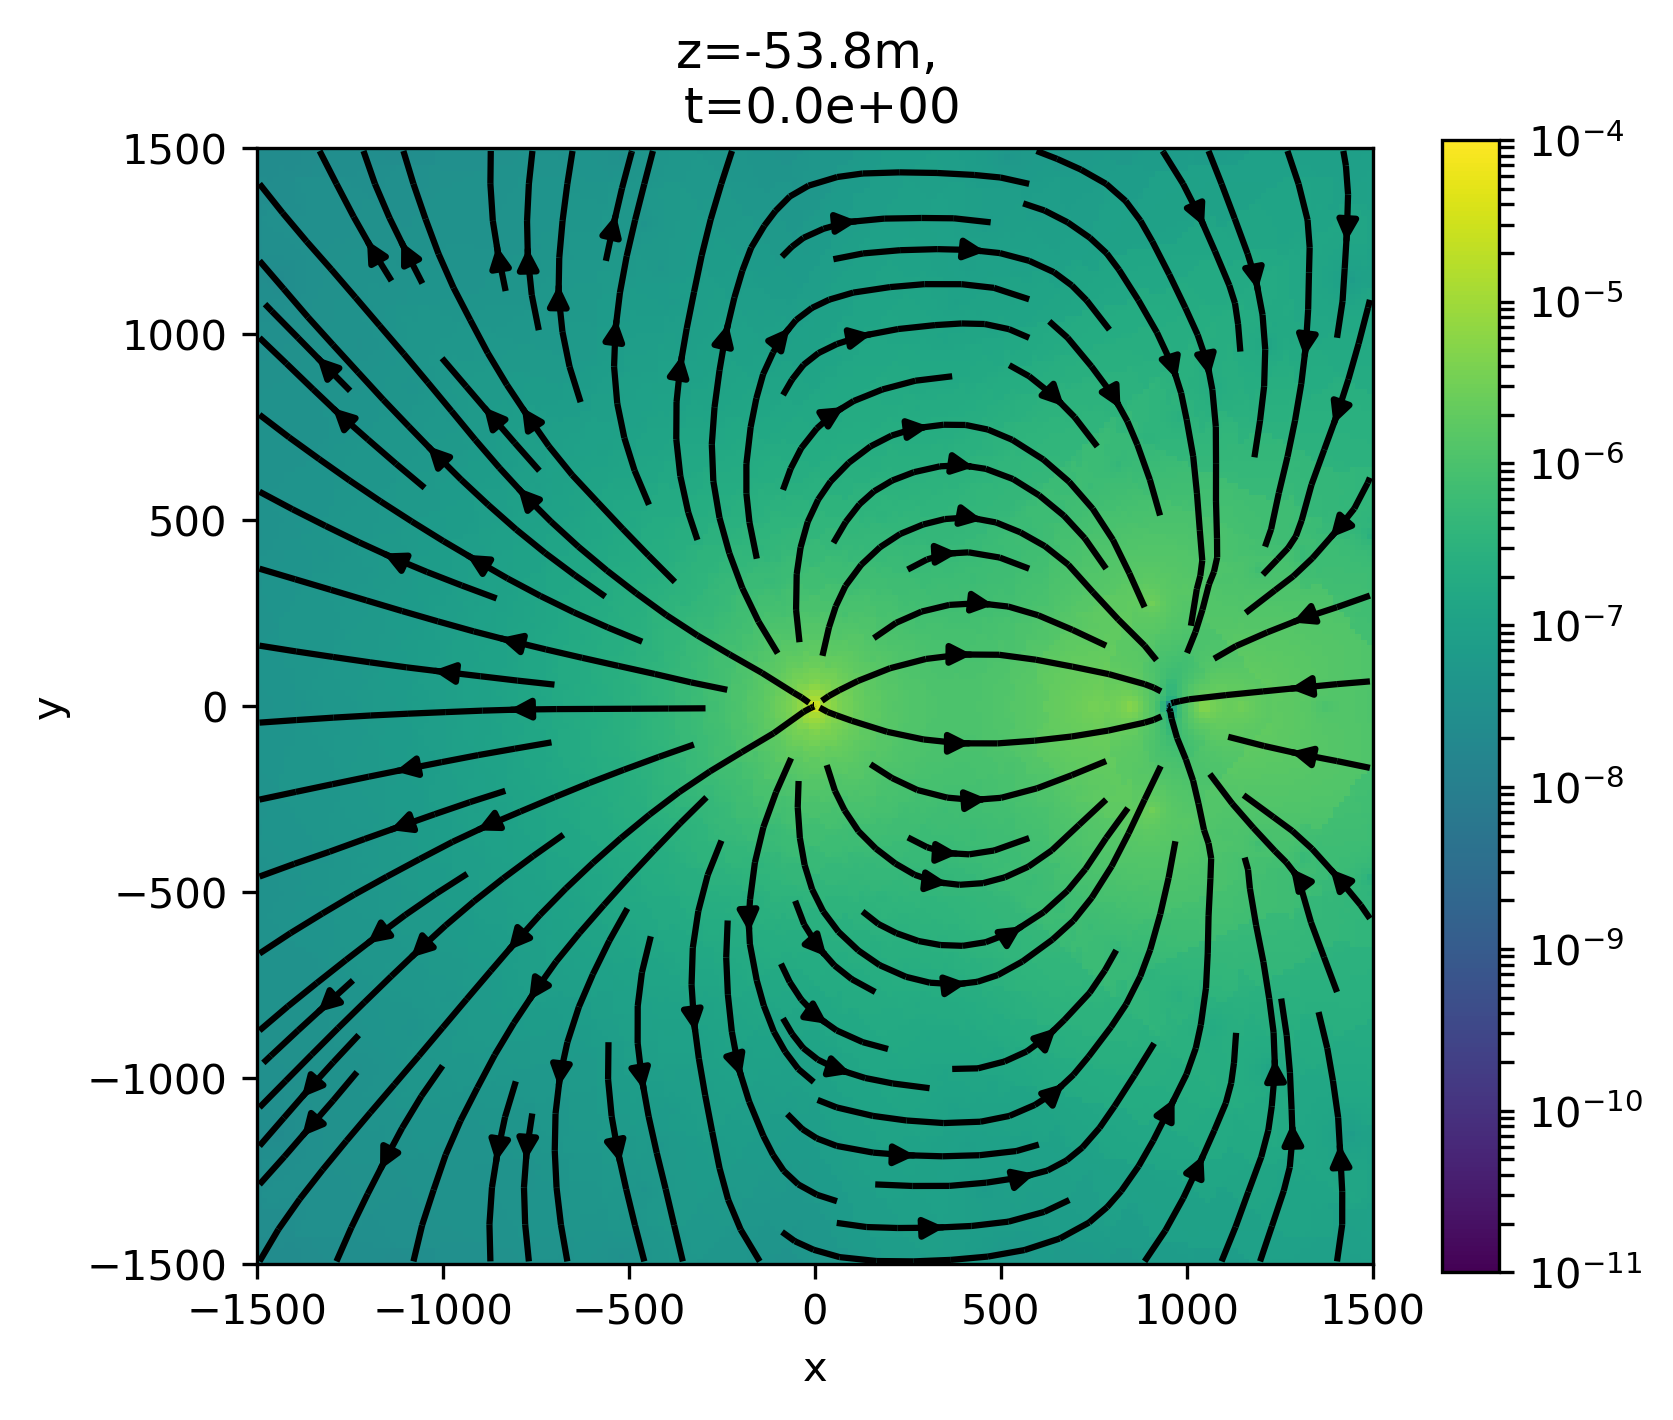

In [47]:
ipywidgets.interact(
    plot_depth_slice,
    z_ind = ipywidgets.IntSlider(min=0, max=cylmesh.vnC[2], value=400),
    time_ind = ipywidgets.IntSlider(min=0, max=len(sim.prob.timeSteps), value=0),
    mod = ipywidgets.ToggleButtons(options=['casing', 'background', 'difference'], value='casing'),
    clim_min = ipywidgets.FloatText(value=1e-11),
    clim_max = ipywidgets.FloatText(value=1e-4),
    ax = ipywidgets.fixed(None)
)

In [48]:
nC = 200
hx = 0.2*np.ones(nC)/nC
plan_mesh_fine = discretize.TensorMesh([hx, hx], x0='CC')

In [49]:
CCcart = meshGen.mesh.cartesianGrid('CC')

In [50]:
tree_fine = cKDTree(CCcart[:cylmesh.vnC[:2].prod(),:2])
d_fine, ii_fine = tree_fine.query(plan_mesh_fine.gridCC, k=3)
inds_fine = np.vstack([ii_fine, ii_fine+cylmesh.vnC[:2].prod()])

In [51]:
weights_fine = 1./d_fine
weights_fine = utils.sdiag(1./weights_fine.sum(1))*weights_fine
weights_fine = np.vstack([weights_fine, weights_fine])

In [52]:
clim_max=1e1
clim_min=1e-8

def plot_depth_slice_through_casing(
    time_ind=0,
    z_ind=400,
    ax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
    
    jCC = cylmesh.aveF2CCV * fields[:, 'j', time_ind]
    jCC_cart = rotate_cyl2cart(jCC.reshape((cylmesh.nC, 3), order='F'), cylmesh.gridCC)
    
    jCCx = (jCC_cart[:, 0]).reshape(cylmesh.vnC, order='F')
    jCCy = (jCC_cart[:, 1]).reshape(cylmesh.vnC, order='F')
    
    jCCx_plt = utils.mkvc(jCCx[:, :, z_ind])
    jCCy_plt = utils.mkvc(jCCy[:, :, z_ind])
    jCC_plt = np.hstack([jCCx_plt, jCCy_plt])
    
    plot_me = (jCC_plt[inds_fine]*weights_fine).sum(1)

    ax.set_title("z={:1.1f}m, \n t={:1.1e}".format(
        cylmesh.vectorCCz[z_ind], sim.prob.times[time_ind]
    ))

    cb = plt.colorbar(plan_mesh_fine.plotImage(
        plot_me, view='vec', vType='CCv', ax=ax, pcolorOpts={'norm':LogNorm()},
        clim = [clim_min, clim_max]
    )[0], ax=ax)
    
    plt.show()

In [53]:
ipywidgets.interact(
    plot_depth_slice_through_casing,
    z_ind = ipywidgets.IntSlider(min=0, max=cylmesh.vnC[2], value=400),
    time_ind = ipywidgets.IntSlider(min=0, max=len(sim.prob.timeSteps), value=0),
    ax = ipywidgets.fixed(None)
)

<function __main__.plot_depth_slice_through_casing>

# Print Figures

In [54]:
from matplotlib import rcParams
from matplotlib import gridspec
rcParams['font.size'] = 16

In [55]:
plt_times = [0, 10, 28, 73, 118, 136]
print(sim.prob.times[plt_times])

[0.000e+00 1.000e-05 1.000e-04 1.010e-03 5.020e-03 1.002e-02]


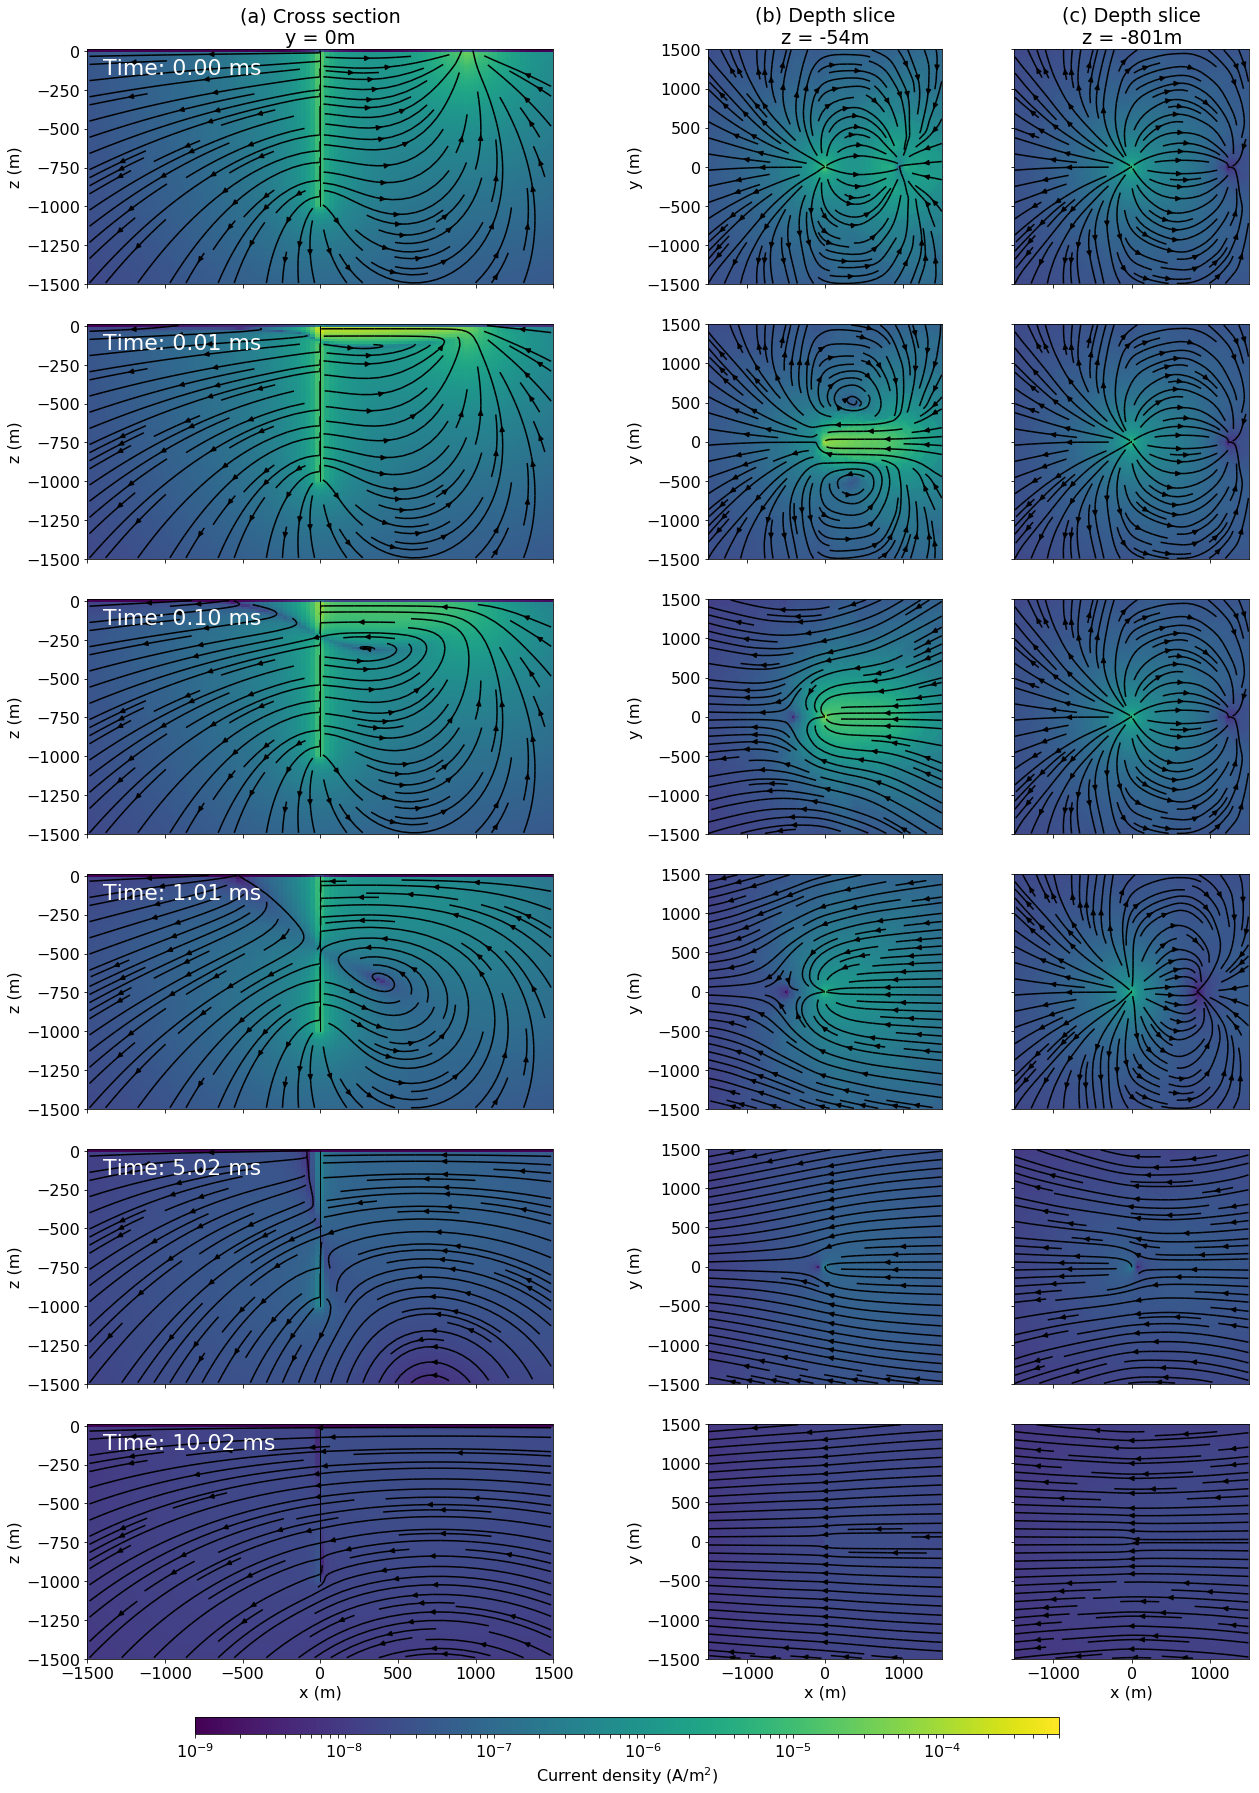

In [56]:
# mod = ['3D']
clim_max = 6e-4 
clim_min = 1e-9


zinds = [400, 101]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(20, 4*len(plt_times))) 
fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 3, width_ratios=[2, 1, 1]) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*3)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*3]
    ax1 = ax[i*3 + 1]
    ax2 = ax[i*3 + 2]
    
    # currents in the formation
    plotCasingResults(
        ax = ax0,
        clim_max=clim_max, clim_min=clim_min, 
        max_depth=1.5*casing_l, 
        max_r=1.5*casing_l, top=10, view='j',
        casing_outline=True, 
        theta_ind=3,
        time_ind=tind,
        mod='casing',
        show_cb=False
    )
    
    ax0.text(-1400, -150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    ax0.set_ylabel('z (m)')
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = plot_depth_slice(
            z_ind = z_ind,
            time_ind = tind,
            mod = 'casing',
            clim_min = clim_min,
            clim_max = clim_max,
            ax = a,
            show_cb=False
        )

    
    for a in [ax0, ax1, ax2]:
        a.set_title('')
        a.set_aspect(1)
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a == ax2:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax1:
            a.set_ylabel('y (m)')
            
    if tind == 0:
        ax0.set_title('(a) Cross section\ny = 0m')
        ax1.set_title('(b) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
        ax2.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]]))  
        
plt.tight_layout()

cbar_ax = fig.add_axes([0.2, -0.01, 0.6, 0.01])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')
#     plt.show()

In [57]:
# fig.savefig('tdem_currents', dpi=300, bbox_inches='tight')

In [58]:
# sim.prob.times[[0, 10, 28, 73, 118, 136]]

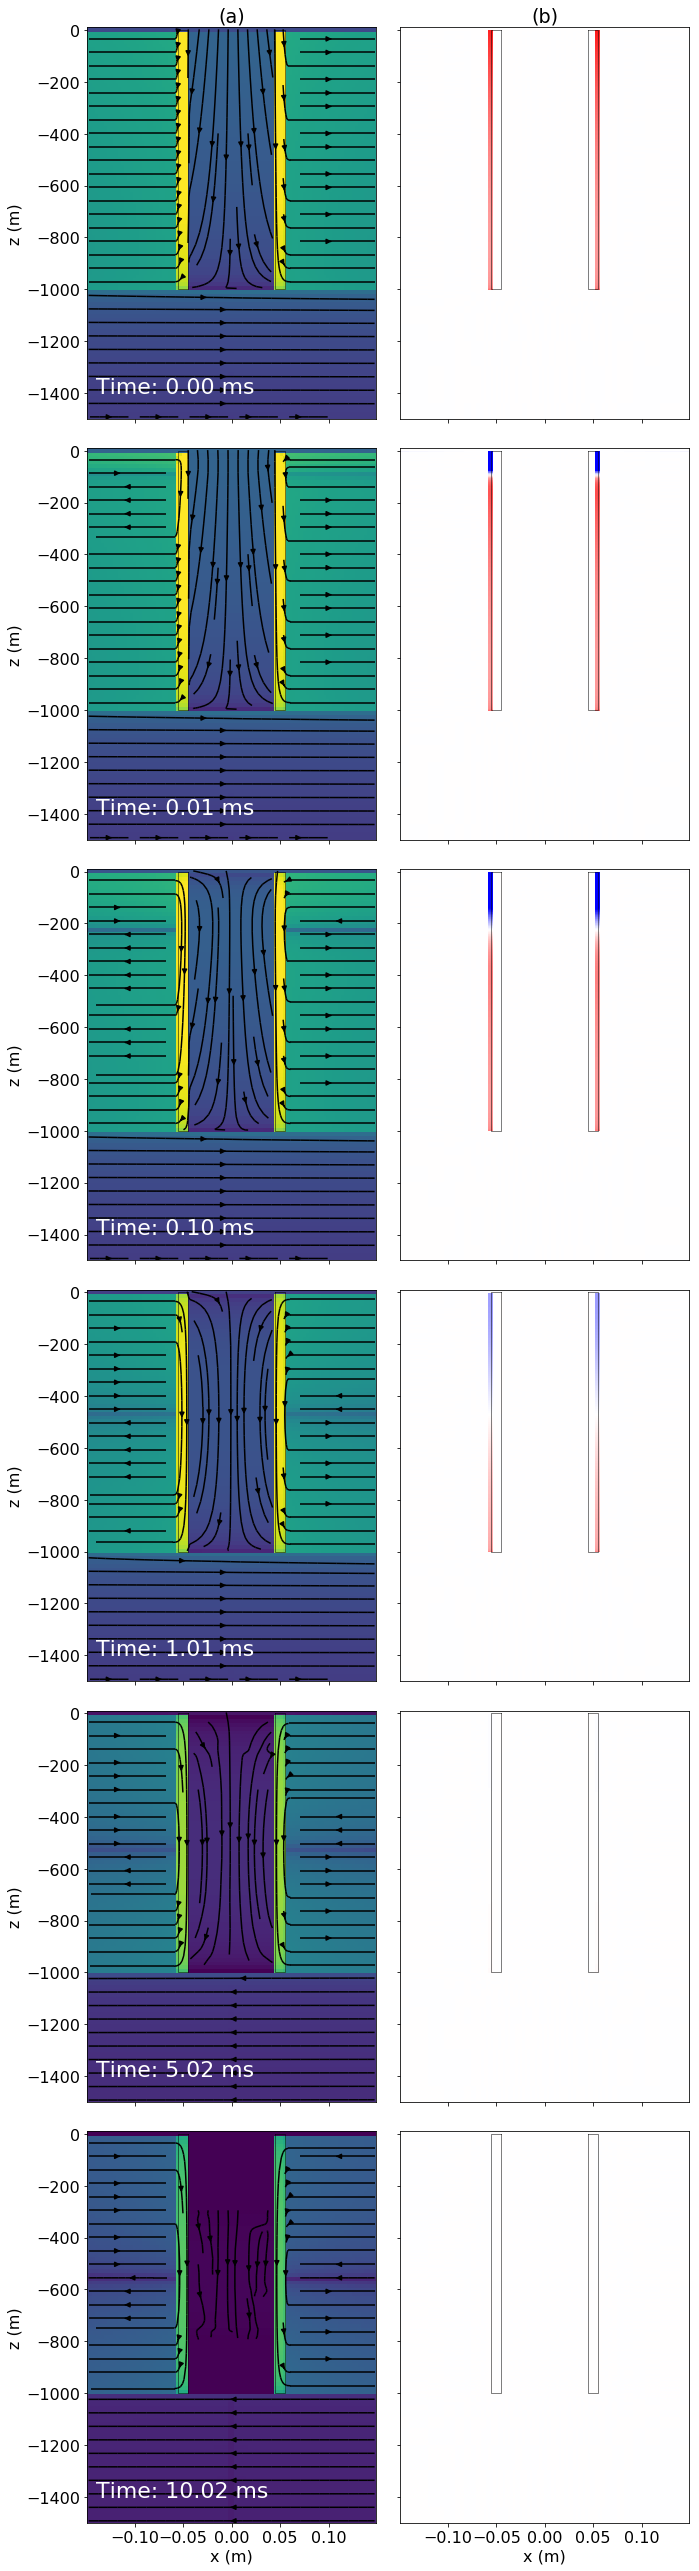

In [59]:
# mod = ['3D']

fig, ax = plt.subplots(len(plt_times), 2, figsize=(10, 6*len(plt_times))) 
fig.subplots_adjust(bottom=0.8)
ax=ax.flatten()

clim_max_currents = 1e2
clim_min_currents = 1e-9
clim_charges = 1e-13

for i, tind in enumerate(plt_times):
# tind = 136
#     fig, ax = plt.subplots(1, len(mod), figsize=(5*len(mod), 6))
    
    ax0 = ax[i*2]
    ax1 = ax[i*2 + 1]
    
    # currents 
    out_j = plotCasingResults(
        ax = ax0,
        clim_max=clim_max_currents, clim_min=clim_min_currents, 
        max_depth=1.5*model.casing_l, 
        max_r=0.149, top=10, view='j',
        casing_outline=True, 
        theta_ind=3,
        time_ind=tind,
        mod='casing',
        show_cb=False
    )
    
    ax0.text(-0.14, -1400, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    
    # currents 
    out_c = plotCasingResults(
        ax = ax1,
        clim_max=clim_charges, clim_min=-1*clim_charges, 
        max_depth=1.5*model.casing_l, 
        max_r=0.149, top=10, view='charge',
        casing_outline=True, 
        theta_ind=3,
        time_ind=tind,
        mod='casing',
        show_cb=False
    )
    
    for a in [ax0, ax1]:
        a.set_title('')
        
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a == ax1:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax0:
            a.set_ylabel('z (m)')
            
    if tind == 0:
        ax0.set_title('(a)')
        ax1.set_title('(b)')

plt.tight_layout()
plt.show()

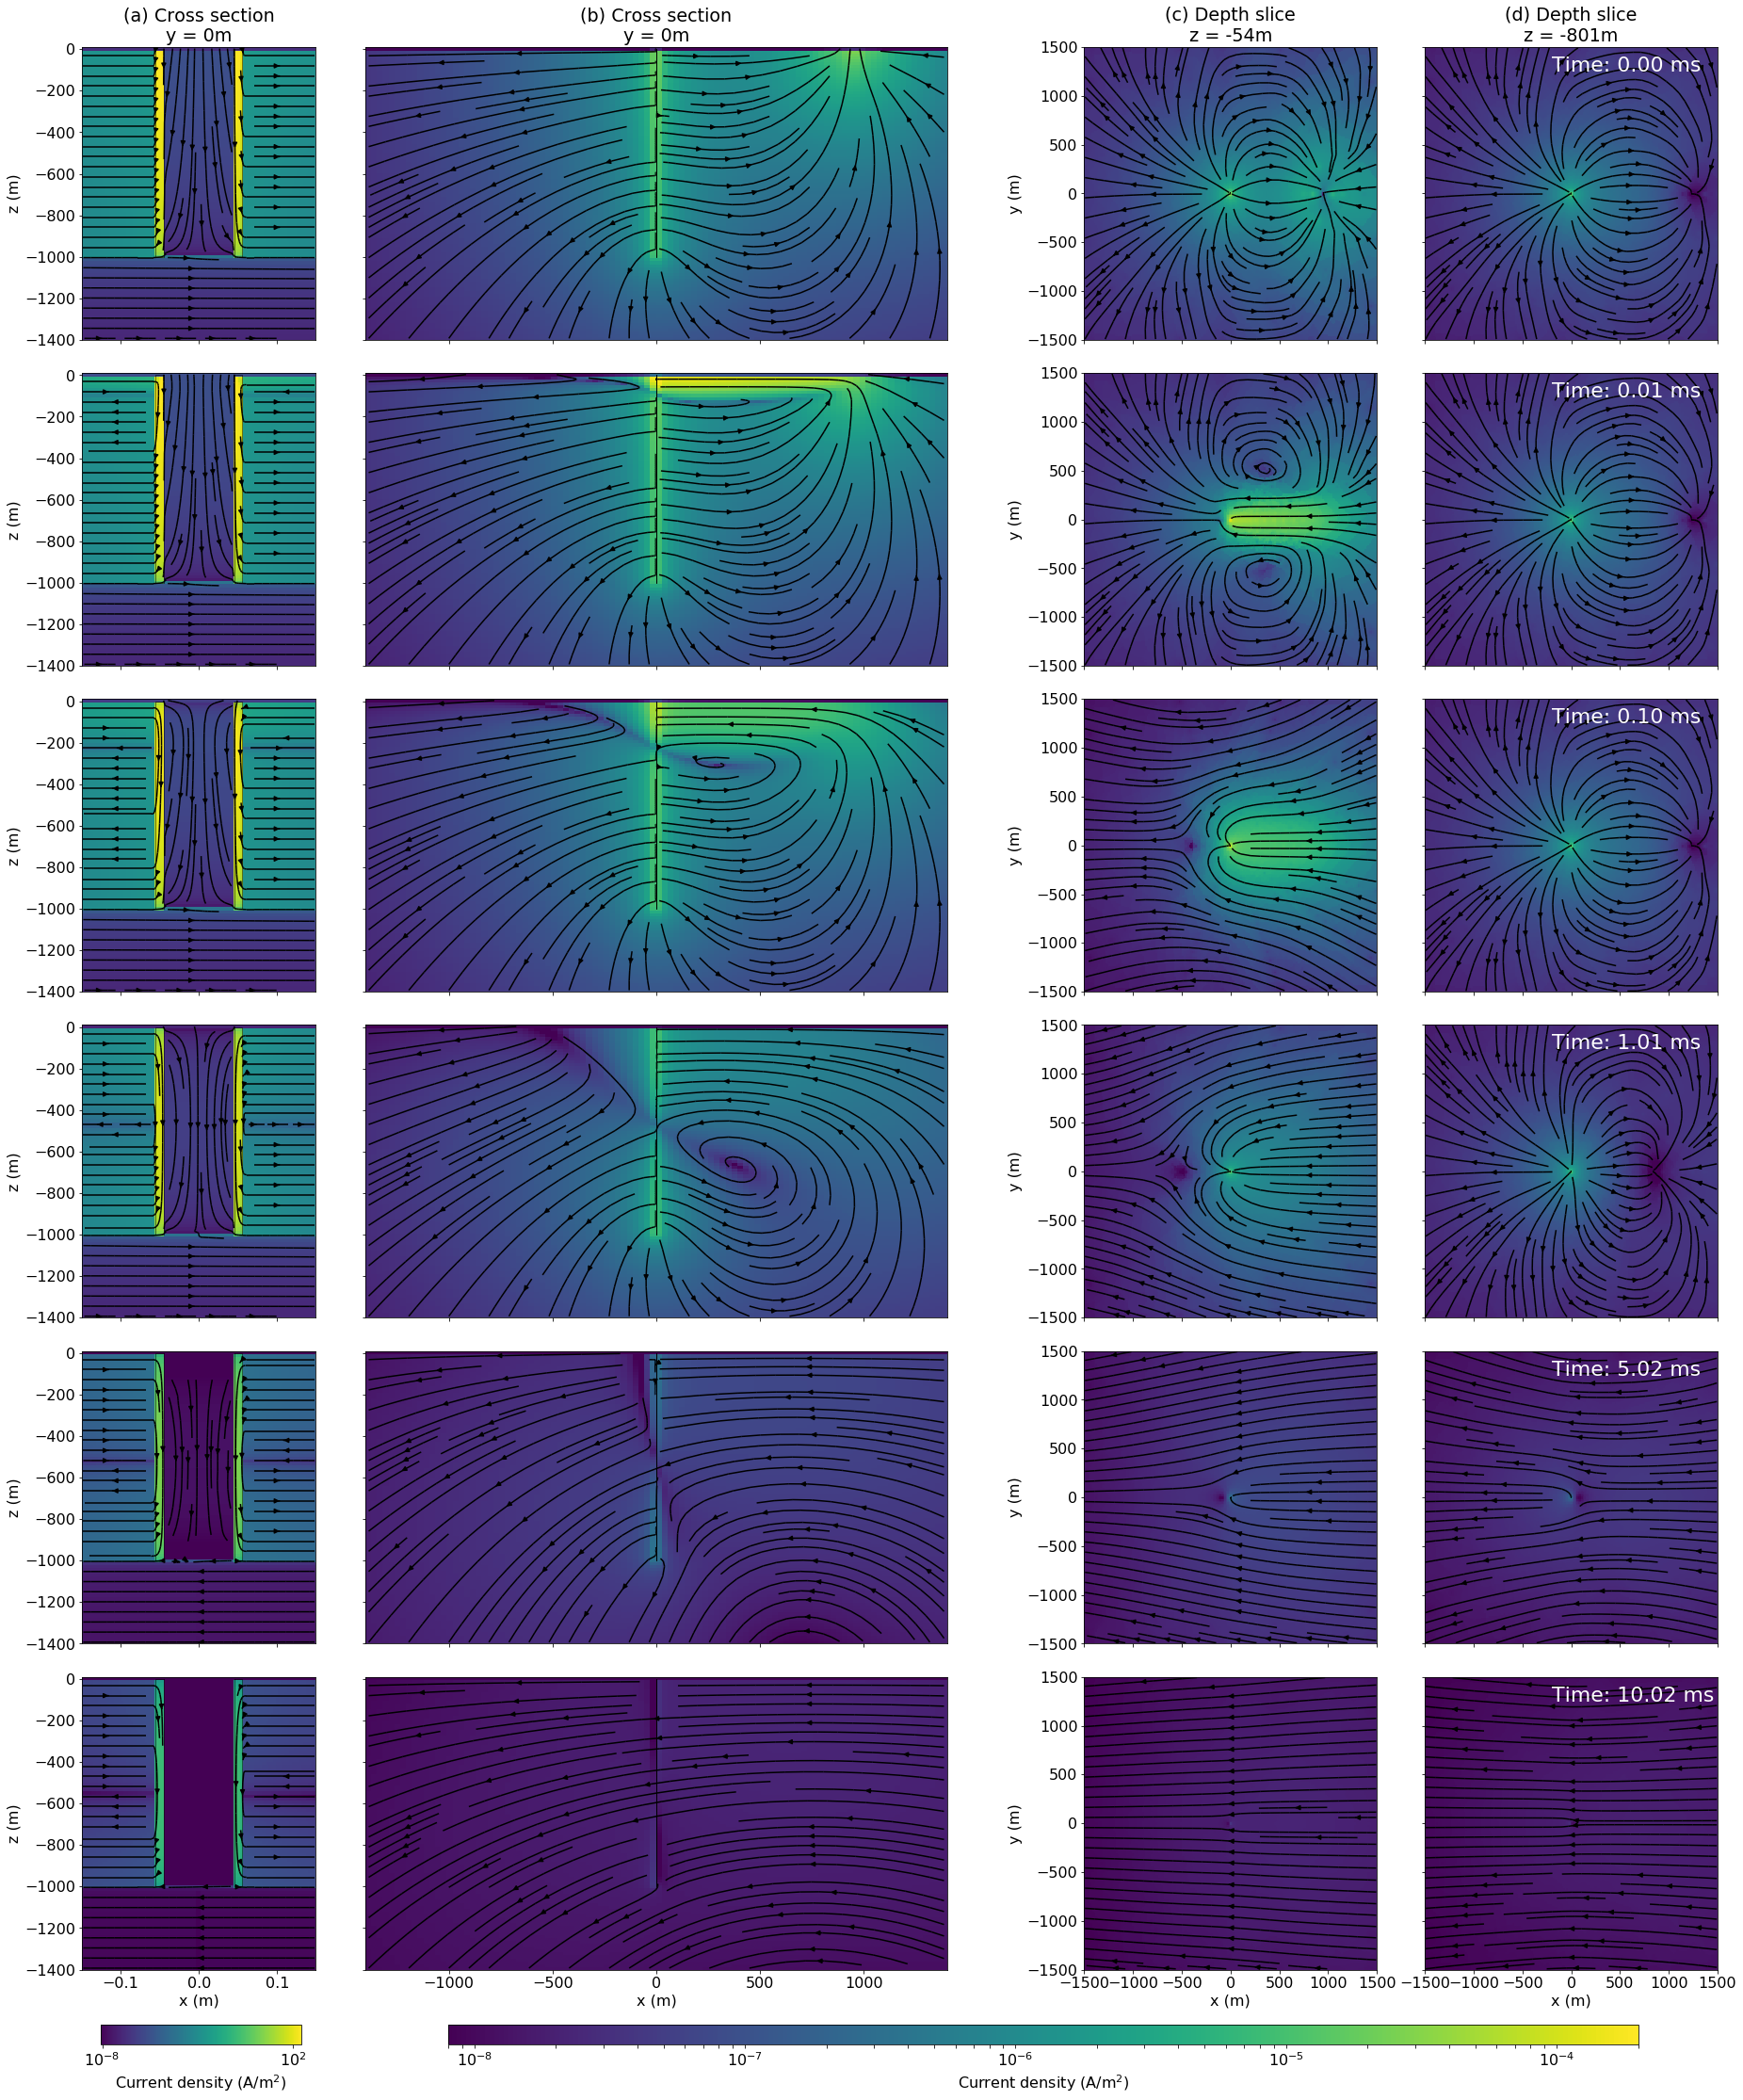

In [60]:
# mod = ['3D']
clim_max = 2e-4 
clim_min = 8e-9

clim_max_casing = 3e2
clim_min_casing = 8e-9

max_depth = 1.4*casing_l

zinds = [400, 101]

z_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(27, 5*len(plt_times))) 
fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 4, width_ratios=[1, 4, 2, 2]) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*4 + 1]
    ax1 = ax[i*4 + 2]
    ax2 = ax[i*4 + 3]
    ax3 = ax[i*4]
    
    # currents in the formation
    plotCasingResults(
        ax = ax0,
        clim_max=clim_max, clim_min=clim_min, 
        max_depth=max_depth, 
        max_r=max_depth, top=10, view='j',
        casing_outline=True, 
        theta_ind=3,
        time_ind=tind,
        mod='casing',
        show_cb=False
    )
        
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = plot_depth_slice(
            z_ind = z_ind,
            time_ind = tind,
            mod = 'casing',
            clim_min = clim_min,
            clim_max = clim_max,
            ax = a,
            show_cb=False
        )
    
    ax2.text(-200, 1250, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)

    
    # zoomed in plot
    out_casing = plotCasingResults(
        ax = ax3,
        clim_max=clim_max_casing, clim_min=clim_min_casing, 
        max_depth=max_depth, 
        max_r=0.149, top=10, view='j',
        casing_outline=True, 
        theta_ind=3,
        time_ind=tind,
        mod='casing',
        show_cb=False
    )

    ax3.set_ylabel('z (m)')
#     ax3.set_yticks(z_ticks)
    
    for a in [ax0, ax1, ax2, ax3]:
        a.set_title('')
        if a != ax3: 
            a.set_aspect(1)
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax2, ax0]:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax1:
            a.set_ylabel('y (m)')
        
            
    if tind == 0:
        ax0.set_title('(b) Cross section\ny = 0m')
        ax1.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
        ax2.set_title('(d) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
        ax3.set_title('(a) Cross section\ny = 0m')
        
plt.tight_layout()

cbar_ax = fig.add_axes([0.25, -0.01, 0.65, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

cbar_ax2 = fig.add_axes([0.06, -0.01, 0.11, 0.01])
cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
cb2.set_label('Current density (A/m$^2$)')
cb2.set_ticks([1e-8, 1e2])
cb2.update_ticks()
#     plt.show()

In [65]:
# fig.savefig('tdem_currents', bbox_inches='tight', dpi=300)